# Examples of plots and calculations using the tmm package

## Imports

In [1]:
from __future__ import division, print_function, absolute_import

from tmm import (coh_tmm, unpolarized_RT, ellips,
                       position_resolved, find_in_structure_with_inf)

from numpy import pi, linspace, inf, array
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

## Set up

In [2]:
try:
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color
    colors_were_imported = True
except ImportError:
    # without colorpy, you can't run sample5(), but everything else is fine.
    colors_were_imported = False


# "5 * degree" is 5 degrees expressed in radians
# "1.2 / degree" is 1.2 radians expressed in degrees
degree = pi/180

__name__ and __package__ in site-packages version: tmm.color , None


## Sample 1

Here's a thin non-absorbing layer, on top of a thick absorbing layer, with
air on both sides. Plotting reflected intensity versus wavenumber, at two
different incident angles.


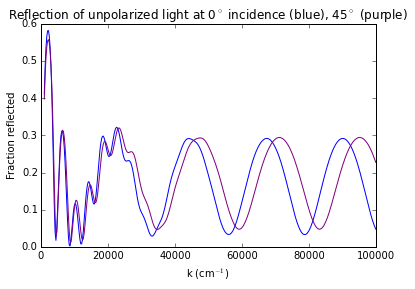

In [3]:
# list of layer thicknesses in nm
d_list = [inf,100,300,inf]
# list of refractive indices
n_list = [1,2.2,3.3+0.3j,1]
# list of wavenumbers to plot in nm^-1
ks=linspace(0.0001,.01,num=400)
# initialize lists of y-values to plot
Rnorm=[] 
R45=[]
for k in ks:
    # For normal incidence, s and p polarizations are identical.
    # I arbitrarily decided to use 's'.
    Rnorm.append(coh_tmm('s',n_list, d_list, 0, 1/k)['R'])
    R45.append(unpolarized_RT(n_list, d_list, 45*degree, 1/k)['R'])
kcm = ks * 1e7 #ks in cm^-1 rather than nm^-1
plt.figure()
plt.plot(kcm,Rnorm,'blue',kcm,R45,'purple')
plt.xlabel('k (cm$^{-1}$)')
plt.ylabel('Fraction reflected')
plt.title('Reflection of unpolarized light at 0$^\circ$ incidence (blue), '
            '45$^\circ$ (purple)');

## Sample 2

Here's the transmitted intensity versus wavelength through a single-layer
film which has some complicated wavelength-dependent index of refraction.
(I made these numbers up, but in real life they could be read out of a
graph / table published in the literature.) Air is on both sides of the
film, and the light is normally incident.

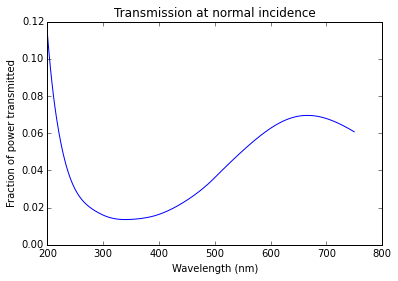

In [4]:
#index of refraction of my material: wavelength in nm versus index.
material_nk_data = array([[200, 2.1+0.1j],
                          [300, 2.4+0.3j],
                          [400, 2.3+0.4j],
                          [500, 2.2+0.4j],
                          [750, 2.2+0.5j]])
material_nk_fn = interp1d(material_nk_data[:,0].real,
                          material_nk_data[:,1], kind='quadratic')
d_list = [inf,300,inf] #in nm
lambda_list = linspace(200,750,400) #in nm
T_list = []
for lambda_vac in lambda_list:
    n_list = [1, material_nk_fn(lambda_vac), 1]
    T_list.append(coh_tmm('s',n_list,d_list,0,lambda_vac)['T'])
plt.figure()
plt.plot(lambda_list,T_list)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Fraction of power transmitted')
plt.title('Transmission at normal incidence');


## Sample 3

Here is a calculation of the psi and Delta parameters measured in
ellipsometry. This reproduces Fig. 1.14 in Handbook of Ellipsometry by
Tompkins, 2005.

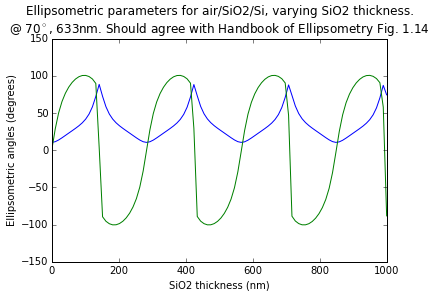

In [5]:
n_list=[1,1.46,3.87+0.02j]
ds=linspace(0,1000,num=100) #in nm
psis=[]
Deltas=[]
for d in ds:
    e_data=ellips(n_list, [inf,d,inf], 70*degree, 633) #in nm
    psis.append(e_data['psi']/degree) # angle in degrees
    Deltas.append(e_data['Delta']/degree) # angle in degrees
plt.figure()
plt.plot(ds,psis,ds,Deltas)
plt.xlabel('SiO2 thickness (nm)')
plt.ylabel('Ellipsometric angles (degrees)')
plt.title('Ellipsometric parameters for air/SiO2/Si, varying '
        'SiO2 thickness.\n' 
        '@ 70$^\circ$, 633nm. '
        'Should agree with Handbook of Ellipsometry Fig. 1.14');

# Sample 4

Here is an example where we plot absorption and Poynting vector
as a function of depth.

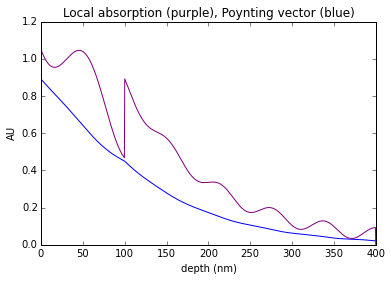

In [6]:
d_list = [inf, 100, 300, inf] #in nm
n_list = [1, 2.2+0.2j, 3.3+0.3j, 1]
th_0=pi/4
lam_vac=400
pol='p'
coh_tmm_data = coh_tmm(pol,n_list,d_list,th_0,lam_vac)

ds = linspace(0,400,num=1000) #position in structure
poyn=[]
absor=[]
for d in ds:
    layer, d_in_layer = find_in_structure_with_inf(d_list,d)
    data=position_resolved(layer,d_in_layer,coh_tmm_data)
    poyn.append(data['poyn'])
    absor.append(data['absor'])
# convert data to numpy arrays for easy scaling in the plot
poyn = array(poyn)
absor = array(absor)
plt.figure()
plt.plot(ds,poyn,'blue',ds,200*absor,'purple')
plt.xlabel('depth (nm)')
plt.ylabel('AU')
plt.title('Local absorption (purple), Poynting vector (blue)');

# Sample 5

Color calculations: What color is a air / thin SiO2 / Si wafer?

air / 300nm SiO2 / Si --- rgb = [ 0.07281632  0.15136527  0.43237682] , xyY = [0.21695453785914581, 0.20726889780765714, 0.1549495698024714]
Saving plot temp_plot.png
Saving plot temp_plot.png
Making color vs SiO2 thickness graph. Compare to (for example)
http://www.htelabs.com/appnotes/sio2_color_chart_thermal_silicon_dioxide.htm


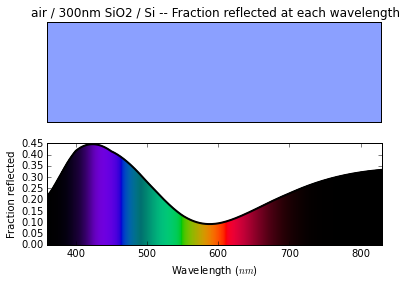

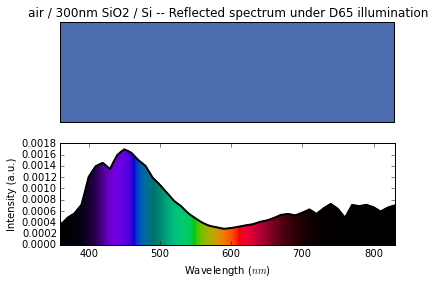

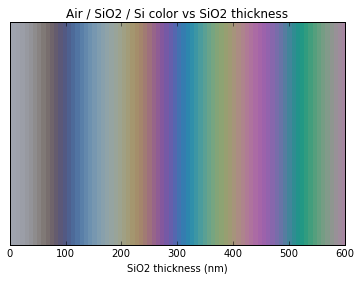

In [7]:
if not colors_were_imported:
    print('Colorpy was not detected (or perhaps an error occurred when',
          'loading it). You cannot do color calculations, sorry!',
          'http://pypi.python.org/pypi/colorpy')
else:

    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1

    n_fn_list = [air_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0

    # Print the colors, and show plots, for the special case of 300nm-thick SiO2
    d_list = [inf, 300, inf]
    reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
    illuminant = colorpy.illuminants.get_illuminant_D65()
    spectrum = color.calc_spectrum(reflectances, illuminant)
    color_dict = color.calc_color(spectrum)
    print('air / 300nm SiO2 / Si --- rgb =', color_dict['rgb'], ', xyY =', color_dict['xyY'])
    plt.figure()
    color.plot_reflectances(reflectances,
                        title='air / 300nm SiO2 / Si -- '
                              'Fraction reflected at each wavelength')
    plt.figure()
    color.plot_spectrum(spectrum,
                        title='air / 300nm SiO2 / Si -- '
                              'Reflected spectrum under D65 illumination')

    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_SiO2_thickness = 600
    SiO2_thickness_list = linspace(0,max_SiO2_thickness,num=80)
    irgb_list = []
    for SiO2_d in SiO2_thickness_list:
        d_list = [inf, SiO2_d, inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs SiO2 thickness graph. Compare to (for example)')
    print('http://www.htelabs.com/appnotes/sio2_color_chart_thermal_silicon_dioxide.htm')
    plt.figure()
    plt.plot([0,max_SiO2_thickness],[1,1])
    plt.xlim(0,max_SiO2_thickness)
    plt.ylim(0,1)
    plt.xlabel('SiO2 thickness (nm)')
    plt.yticks([])
    plt.title('Air / SiO2 / Si color vs SiO2 thickness')
    for i in range(len(SiO2_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (SiO2_thickness_list[i] + SiO2_thickness_list[i-1]) / 2
        if i == len(SiO2_thickness_list) - 1:
            x1 = max_SiO2_thickness
        else:
            x1 = (SiO2_thickness_list[i] + SiO2_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)
